In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                            | 0/50000 [00:00<?, ?it/s]

  9%|█████▌                                                        | 4457/50000 [00:00<00:01, 44564.52it/s]

 18%|███████████                                                   | 8914/50000 [00:00<00:00, 42563.70it/s]

 27%|████████████████▎                                            | 13370/50000 [00:00<00:00, 43448.36it/s]

 36%|█████████████████████▊                                       | 17863/50000 [00:00<00:00, 44022.63it/s]

 45%|███████████████████████████▎                                 | 22343/50000 [00:00<00:00, 44297.64it/s]

 54%|████████████████████████████████▋                            | 26808/50000 [00:00<00:00, 44414.88it/s]

 63%|██████████████████████████████████████▏                      | 31252/50000 [00:00<00:00, 43235.00it/s]

 71%|███████████████████████████████████████████▍                 | 35583/50000 [00:00<00:00, 43239.49it/s]

 80%|████████████████████████████████████████████████▊            | 40009/50000 [00:00<00:00, 43550.99it/s]

 89%|██████████████████████████████████████████████████████▎      | 44509/50000 [00:01<00:00, 43991.97it/s]

 98%|███████████████████████████████████████████████████████████▋ | 48912/50000 [00:01<00:00, 43907.55it/s]

100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43718.61it/s]

Files already downloaded and verified


  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 41%|█████████████████████████▋                                    | 4135/10000 [00:00<00:00, 41340.08it/s]

 83%|███████████████████████████████████████████████████▎          | 8270/10000 [00:00<00:00, 40930.32it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 41216.64it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 457i8xve


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-457i8xve:best, 314.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.7


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/313 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/313 [00:00<02:45,  1.88it/s]

  5%|███▎                                                                 | 15/313 [00:00<00:09, 30.70it/s]

  9%|██████▍                                                              | 29/313 [00:00<00:05, 54.99it/s]

 14%|█████████▍                                                           | 43/313 [00:00<00:03, 74.76it/s]

 19%|████████████▊                                                        | 58/313 [00:00<00:02, 93.63it/s]

 23%|███████████████▋                                                    | 72/313 [00:01<00:02, 104.31it/s]

 27%|██████████████████▋                                                 | 86/313 [00:01<00:02, 112.12it/s]

 32%|█████████████████████▍                                             | 100/313 [00:01<00:01, 118.65it/s]

 36%|████████████████████████▍                                          | 114/313 [00:01<00:01, 123.32it/s]

 41%|███████████████████████████▍                                       | 128/313 [00:01<00:01, 126.76it/s]

 45%|██████████████████████████████▍                                    | 142/313 [00:01<00:01, 129.15it/s]

 50%|█████████████████████████████████▍                                 | 156/313 [00:01<00:01, 130.92it/s]

 54%|████████████████████████████████████▍                              | 170/313 [00:01<00:01, 132.17it/s]

 59%|███████████████████████████████████████▍                           | 184/313 [00:01<00:00, 132.94it/s]

 63%|██████████████████████████████████████████▍                        | 198/313 [00:01<00:00, 132.87it/s]

 68%|█████████████████████████████████████████████▍                     | 212/313 [00:02<00:00, 133.60it/s]

 72%|████████████████████████████████████████████████▍                  | 226/313 [00:02<00:00, 134.29it/s]

 77%|███████████████████████████████████████████████████▎               | 240/313 [00:02<00:00, 134.66it/s]

 81%|██████████████████████████████████████████████████████▎            | 254/313 [00:02<00:00, 135.00it/s]

 86%|█████████████████████████████████████████████████████████▎         | 268/313 [00:02<00:00, 135.42it/s]

 90%|████████████████████████████████████████████████████████████▎      | 282/313 [00:02<00:00, 135.57it/s]

 95%|███████████████████████████████████████████████████████████████▎   | 296/313 [00:02<00:00, 135.70it/s]

 99%|██████████████████████████████████████████████████████████████████▎| 310/313 [00:02<00:00, 136.30it/s]

100%|███████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 108.00it/s]

train - OK


  0%|                                                                               | 0/79 [00:00<?, ?it/s]

  6%|████▍                                                                  | 5/79 [00:00<00:01, 49.42it/s]

 24%|████████████████▊                                                     | 19/79 [00:00<00:00, 99.96it/s]

 42%|████████████████████████████▊                                        | 33/79 [00:00<00:00, 116.49it/s]

 59%|█████████████████████████████████████████                            | 47/79 [00:00<00:00, 124.34it/s]

 77%|█████████████████████████████████████████████████████▎               | 61/79 [00:00<00:00, 128.21it/s]

 94%|████████████████████████████████████████████████████████████████▋    | 74/79 [00:00<00:00, 127.73it/s]

100%|█████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 110.30it/s]

val - OK


  0%|                                                                               | 0/79 [00:00<?, ?it/s]

  5%|███▌                                                                   | 4/79 [00:00<00:01, 39.38it/s]

 23%|███████████████▉                                                      | 18/79 [00:00<00:00, 95.53it/s]

 35%|████████████████████████▊                                             | 28/79 [00:00<00:00, 70.93it/s]

 46%|███████████████████████████████▉                                      | 36/79 [00:00<00:00, 66.24it/s]

 63%|████████████████████████████████████████████▎                         | 50/79 [00:00<00:00, 86.28it/s]

 80%|███████████████████████████████████████████████████████▊              | 63/79 [00:00<00:00, 96.98it/s]

 94%|█████████████████████████████████████████████████████████████████▌    | 74/79 [00:00<00:00, 91.48it/s]

100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.43it/s]

test InD - OK


  0%|                                                                              | 0/469 [00:00<?, ?it/s]

  0%|▎                                                                     | 2/469 [00:00<00:23, 19.77it/s]

  2%|█▍                                                                   | 10/469 [00:00<00:08, 53.39it/s]

  4%|██▋                                                                  | 18/469 [00:00<00:07, 63.53it/s]

  6%|███▊                                                                 | 26/469 [00:00<00:06, 68.89it/s]

  7%|█████                                                                | 34/469 [00:00<00:06, 71.23it/s]

  9%|██████▏                                                              | 42/469 [00:00<00:05, 73.33it/s]

 11%|███████▎                                                             | 50/469 [00:00<00:05, 73.94it/s]

 12%|████████▌                                                            | 58/469 [00:00<00:05, 75.08it/s]

 14%|█████████▋                                                           | 66/469 [00:00<00:05, 75.12it/s]

 16%|██████████▉                                                          | 74/469 [00:01<00:05, 75.82it/s]

 17%|████████████                                                         | 82/469 [00:01<00:05, 75.60it/s]

 19%|█████████████▏                                                       | 90/469 [00:01<00:04, 76.18it/s]

 21%|██████████████▍                                                      | 98/469 [00:01<00:04, 76.03it/s]

 23%|███████████████▎                                                    | 106/469 [00:01<00:04, 75.73it/s]

 24%|████████████████▌                                                   | 114/469 [00:01<00:04, 76.29it/s]

 26%|█████████████████▋                                                  | 122/469 [00:01<00:04, 75.98it/s]

 28%|██████████████████▊                                                 | 130/469 [00:01<00:04, 76.42it/s]

 29%|████████████████████                                                | 138/469 [00:01<00:04, 76.05it/s]

 31%|█████████████████████▏                                              | 146/469 [00:01<00:04, 76.49it/s]

 33%|██████████████████████▎                                             | 154/469 [00:02<00:04, 75.05it/s]

 35%|███████████████████████▍                                            | 162/469 [00:02<00:04, 75.81it/s]

 36%|████████████████████████▋                                           | 170/469 [00:02<00:03, 76.28it/s]

 38%|█████████████████████████▊                                          | 178/469 [00:02<00:03, 75.96it/s]

 40%|██████████████████████████▉                                         | 186/469 [00:02<00:03, 76.43it/s]

 41%|████████████████████████████▏                                       | 194/469 [00:02<00:03, 76.04it/s]

 43%|█████████████████████████████▎                                      | 202/469 [00:02<00:03, 76.49it/s]

 45%|██████████████████████████████▍                                     | 210/469 [00:02<00:03, 76.17it/s]

 46%|███████████████████████████████▌                                    | 218/469 [00:02<00:03, 76.52it/s]

 48%|████████████████████████████████▊                                   | 226/469 [00:03<00:03, 76.15it/s]

 50%|█████████████████████████████████▉                                  | 234/469 [00:03<00:03, 76.58it/s]

 52%|███████████████████████████████████                                 | 242/469 [00:03<00:02, 76.29it/s]

 53%|████████████████████████████████████▏                               | 250/469 [00:03<00:02, 75.97it/s]

 55%|█████████████████████████████████████▍                              | 258/469 [00:03<00:02, 76.47it/s]

 57%|██████████████████████████████████████▌                             | 266/469 [00:03<00:02, 76.10it/s]

 58%|███████████████████████████████████████▋                            | 274/469 [00:03<00:02, 76.49it/s]

 60%|████████████████████████████████████████▉                           | 282/469 [00:03<00:02, 76.10it/s]

 62%|██████████████████████████████████████████                          | 290/469 [00:03<00:02, 76.53it/s]

 64%|███████████████████████████████████████████▏                        | 298/469 [00:03<00:02, 76.16it/s]

 65%|████████████████████████████████████████████▎                       | 306/469 [00:04<00:02, 76.50it/s]

 67%|█████████████████████████████████████████████▌                      | 314/469 [00:04<00:02, 76.11it/s]

 69%|██████████████████████████████████████████████▋                     | 322/469 [00:04<00:01, 76.54it/s]

 70%|███████████████████████████████████████████████▊                    | 330/469 [00:04<00:01, 76.18it/s]

 72%|█████████████████████████████████████████████████                   | 338/469 [00:04<00:01, 76.61it/s]

 74%|██████████████████████████████████████████████████▏                 | 346/469 [00:04<00:01, 76.25it/s]

 75%|███████████████████████████████████████████████████▎                | 354/469 [00:04<00:01, 76.60it/s]

 77%|████████████████████████████████████████████████████▍               | 362/469 [00:04<00:01, 76.20it/s]

 79%|█████████████████████████████████████████████████████▋              | 370/469 [00:04<00:01, 76.60it/s]

 81%|██████████████████████████████████████████████████████▊             | 378/469 [00:05<00:01, 76.36it/s]

 82%|███████████████████████████████████████████████████████▉            | 386/469 [00:05<00:01, 75.98it/s]

 84%|█████████████████████████████████████████████████████████▏          | 394/469 [00:05<00:00, 76.45it/s]

 86%|██████████████████████████████████████████████████████████▎         | 402/469 [00:05<00:00, 76.06it/s]

 87%|███████████████████████████████████████████████████████████▍        | 410/469 [00:05<00:00, 76.53it/s]

 89%|████████████████████████████████████████████████████████████▌       | 418/469 [00:05<00:00, 76.12it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 426/469 [00:05<00:00, 76.54it/s]

 93%|██████████████████████████████████████████████████████████████▉     | 434/469 [00:05<00:00, 76.16it/s]

 94%|████████████████████████████████████████████████████████████████    | 442/469 [00:05<00:00, 76.52it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 450/469 [00:05<00:00, 76.14it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 458/469 [00:06<00:00, 76.57it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 466/469 [00:06<00:00, 76.14it/s]

100%|████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 74.59it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:01, 76.43it/s]

 16%|███████████                                                          | 16/100 [00:00<00:01, 75.93it/s]

 24%|████████████████▌                                                    | 24/100 [00:00<00:01, 75.59it/s]

 32%|██████████████████████                                               | 32/100 [00:00<00:00, 75.52it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:00<00:00, 75.40it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:00<00:00, 76.16it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:00<00:00, 76.01it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:00<00:00, 76.47it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:00<00:00, 76.09it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:01<00:00, 76.52it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:01<00:00, 76.26it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:01<00:00, 75.92it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 76.15it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 2048) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 2048) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 2048) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 2048) (30000, 512) (30000, 5) (30000,)
(6400, 3, 32, 32) (6400, 2048) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


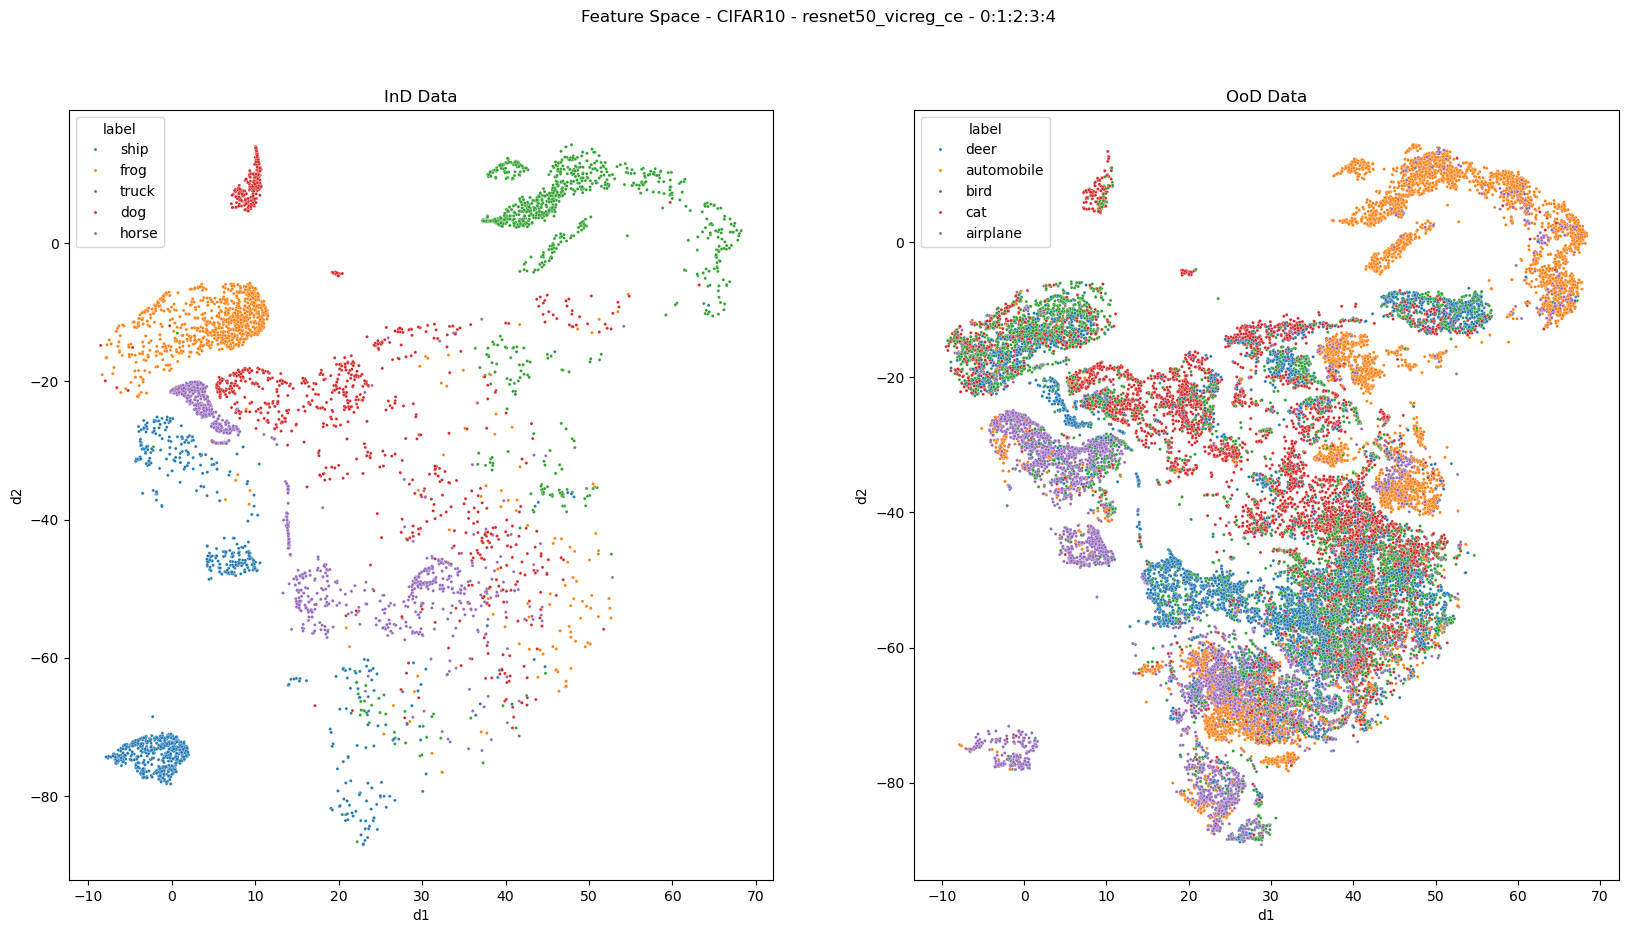

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

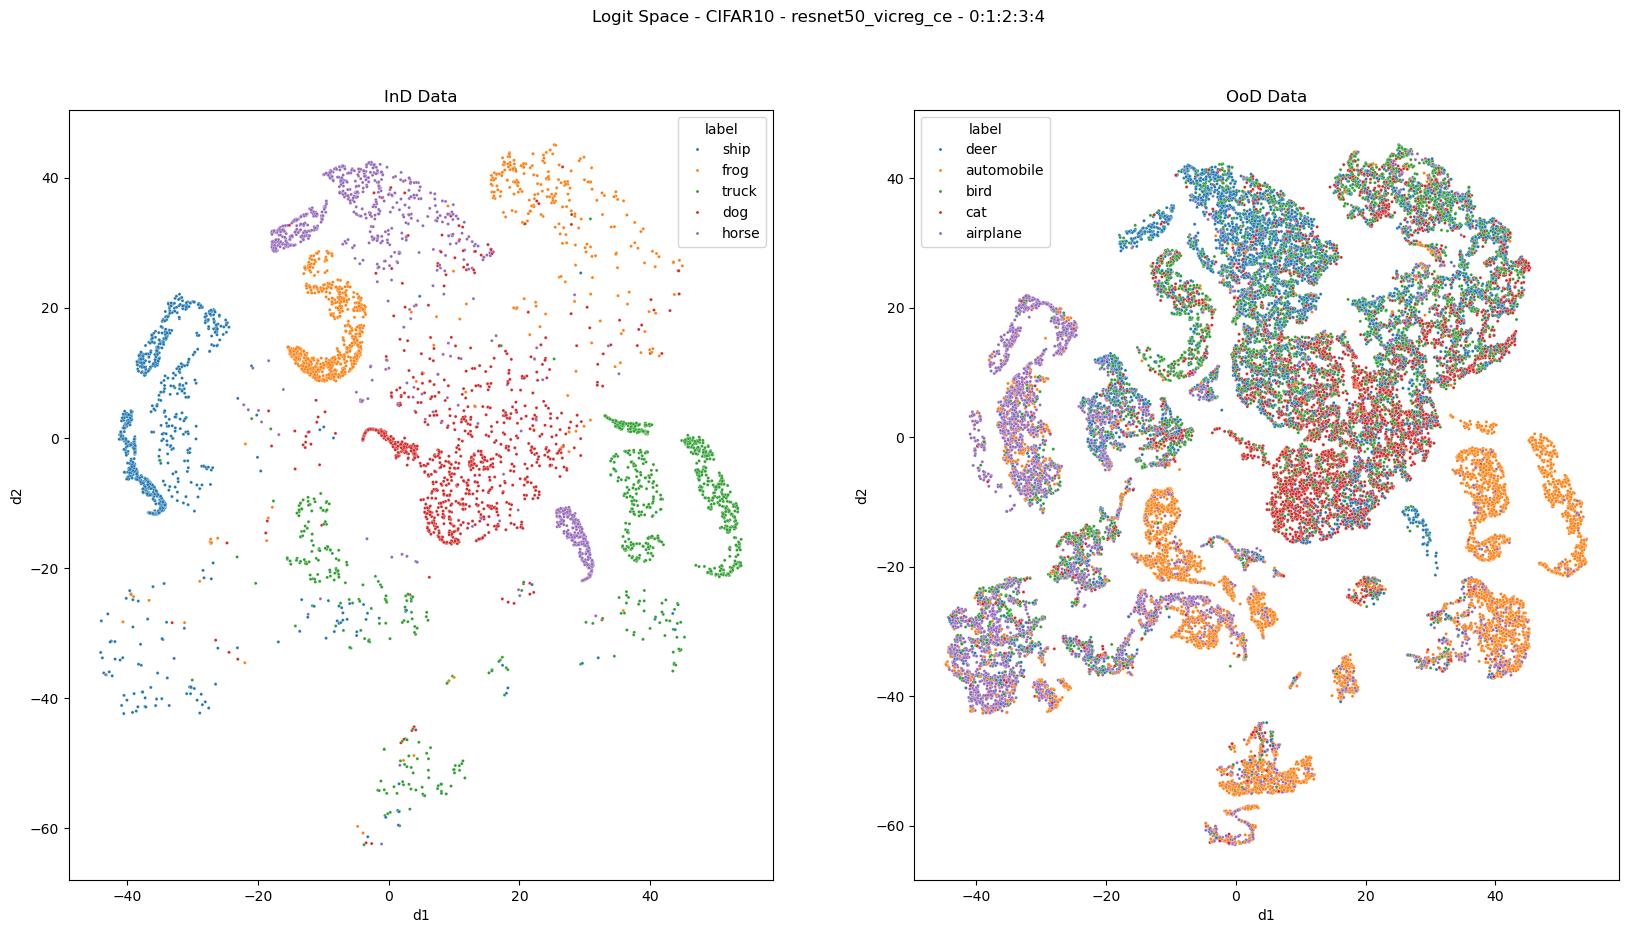

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:04<00:14,  4.77s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:09<00:09,  4.67s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:14<00:04,  4.68s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.74s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.73s/it]

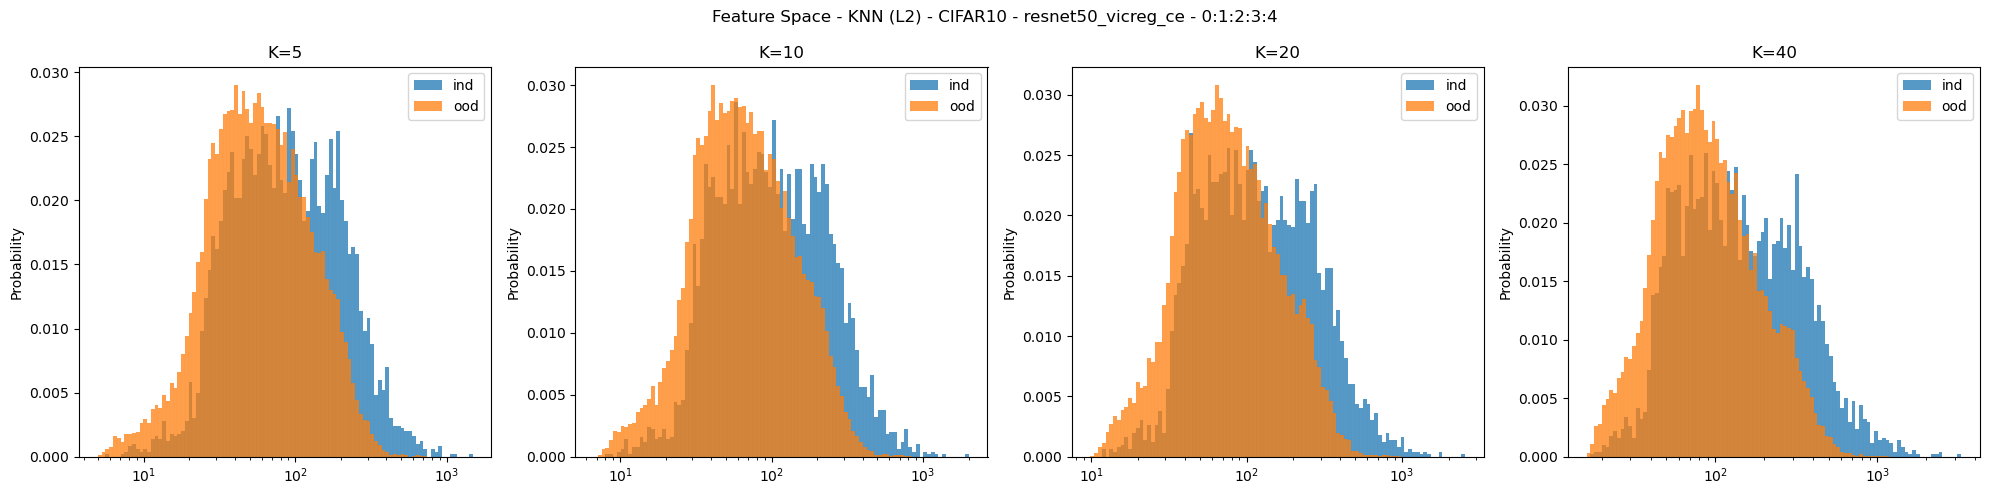

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:04<00:13,  4.52s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:09<00:09,  4.54s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:13<00:04,  4.68s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.72s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.67s/it]

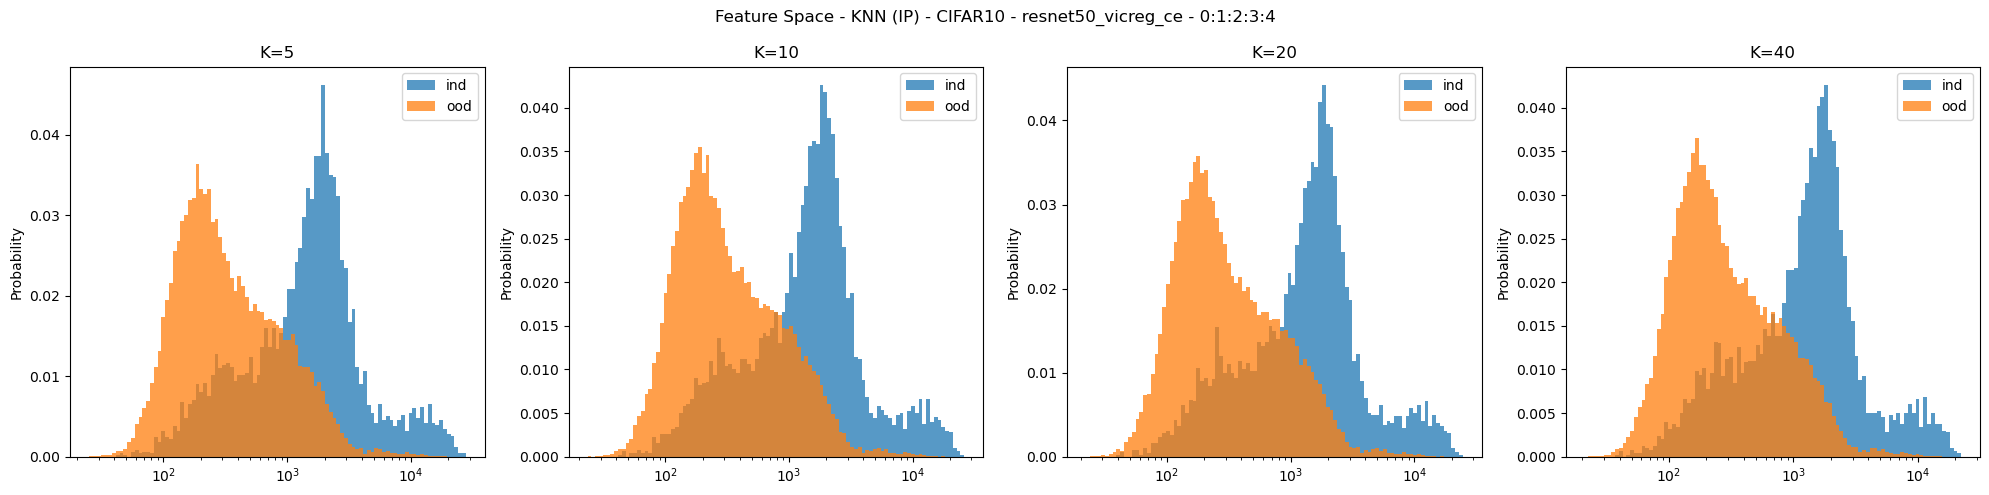

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  3.28it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  3.06it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.72it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]

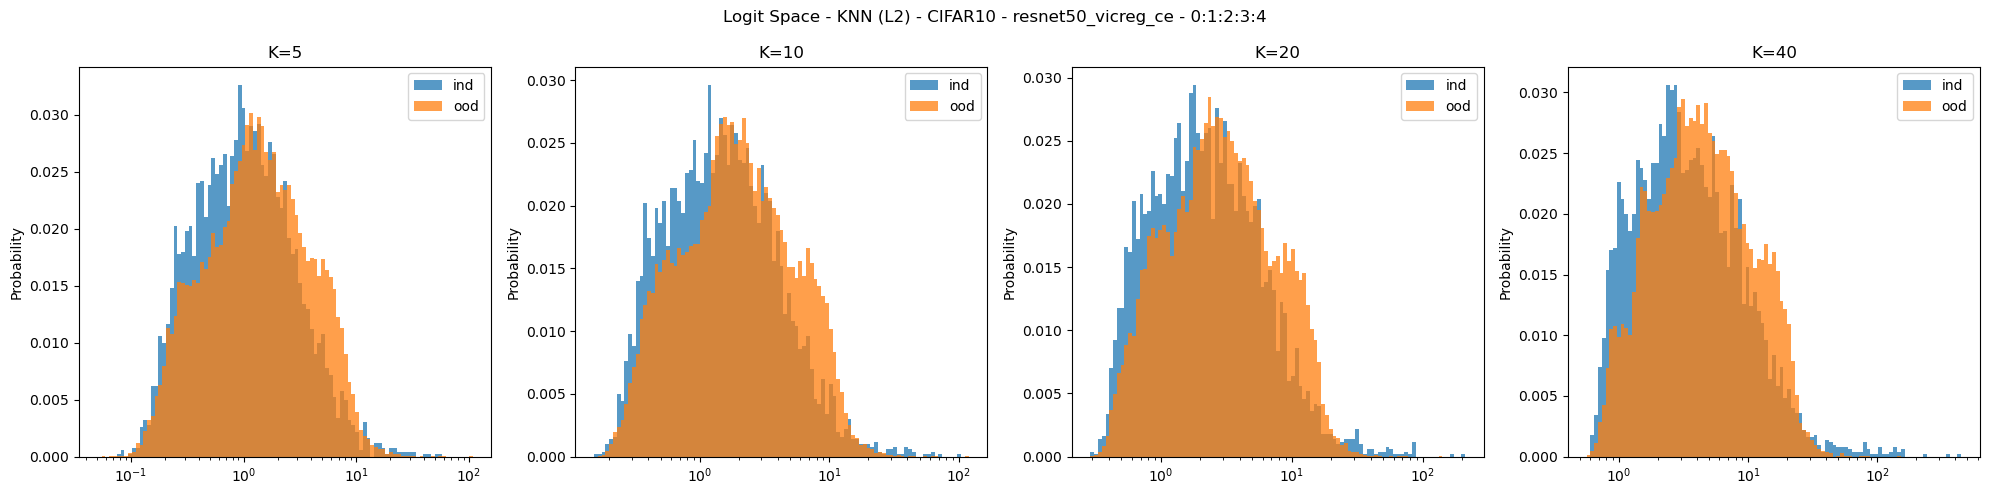

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  1.92it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.52it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.52it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]

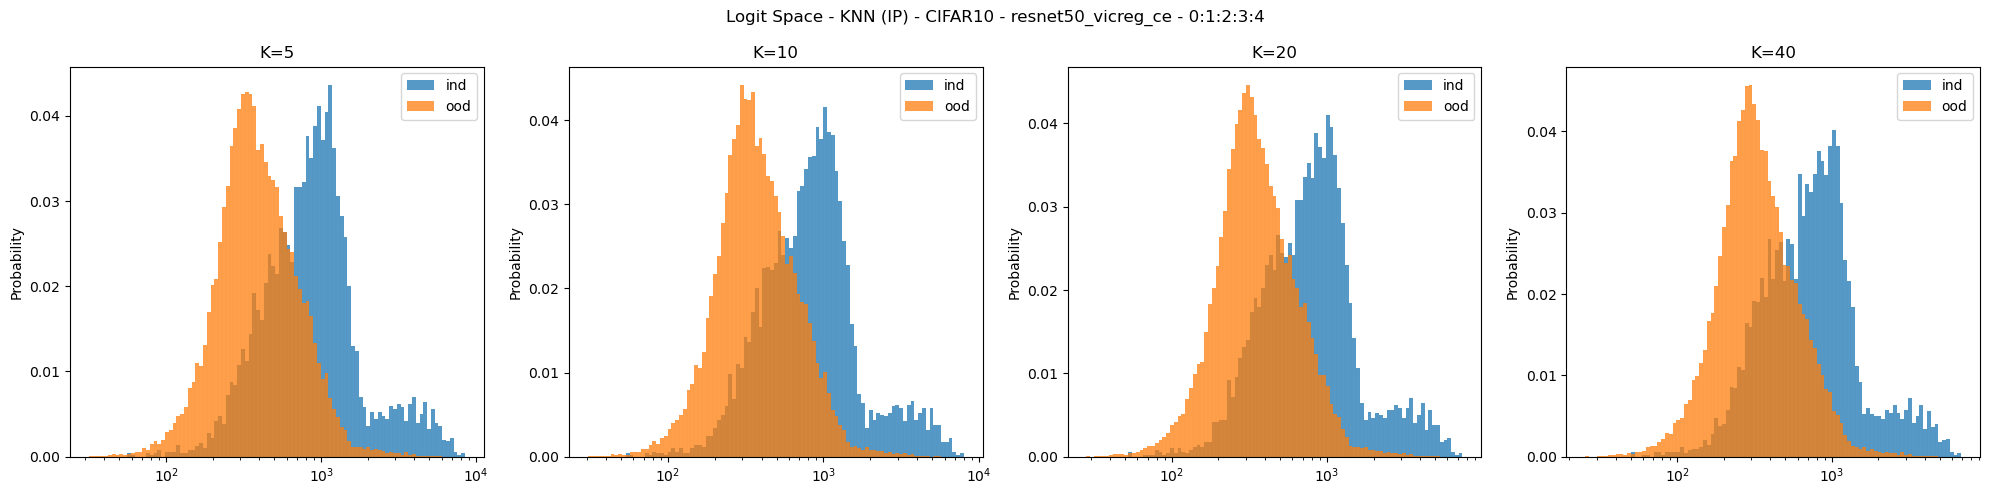

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

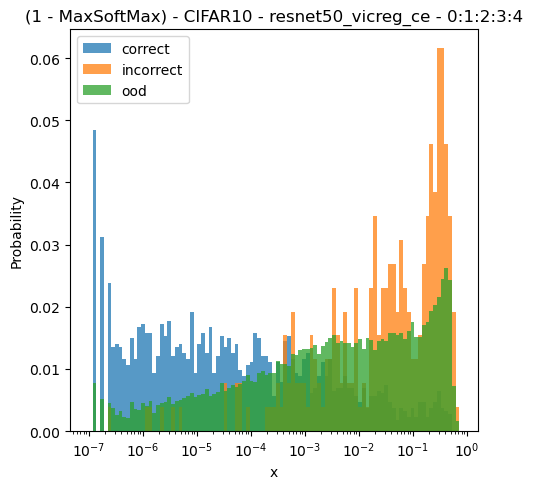

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()